In [137]:
import json
import os
import steady_state_detection as ssd

In [138]:
data_dir = '../data'

forks = {'raphw__byte-buddy#net.bytebuddy.benchmark.ClassByExtensionBenchmark.benchmarkByteBuddyWithAccessorAndReusedDelegatorWithTypePool#.json': 5,
         'eclipse__rdf4j#org.eclipse.rdf4j.benchmark.QueryOrderBenchmark.selectAll#countk=50&limit=10000&syncThreshold=0.json': 9,
         'crate__crate#io.crate.analyze.PreExecutionBenchmark.measureParseAndAnalyzeSimpleSelect#.json': 6,
         'yellowstonegames__SquidLib#squidpony.performance.DataStructureBenchmark.insertIntegerLinkedHashMap2#NEED_TO_ENLARGE=1&SIZE=65536.json': 4,
         'jdbi__jdbi#org.jdbi.v3.benchmark.sqlobject.H2SqlObjectV3Benchmark.attach#.json': 7,
         'cantaloupe-project__cantaloupe#edu.illinois.library.cantaloupe.perf.processor.codec.TIFFImageWriterPerformance.testWriteWithPlanarImage#.json': 1,
         'jgrapht__jgrapht#org.jgrapht.perf.connectivity.TreeDynamicConnectivityPerformanceTest.testTreeDynamicConnectivity#treeSize=1000.json': 7,
         'eclipse__jetty.project#org.eclipse.jetty.util.PoolStrategyBenchmark.testAcquireReleasePoolWithStrategy#CACHE=true&POOL_TYPE=Pool.RoundRobin&SIZE=16.json': 8,
         'RoaringBitmap__RoaringBitmap#org.roaringbitmap.iteration.BatchIteratorBenchmark.iterate#bufferSize=512&dirtiness=0.1&keys=2096&runniness=0.1.json': 3,
         'zalando__logbook#org.zalando.logbook.HttpLogFormatterBenchmark.fastJsonResponse#.json': 3,
         'apache__logging-log4j2#org.apache.logging.log4j.layout.template.json.JsonTemplateLayoutBenchmark.fullCustomJsonLayout#.json': 0,
         'apache__tinkerpop#org.apache.tinkerpop.gremlin.driver.GraphSONMapperBenchmark.readBytecode2#.json': 2,
         'prestodb__presto#com.facebook.presto.operator.scalar.StringFunctionsBenchmark.benchmarkSubstringStartLengthFromEnd#ascii=false&length=10.json': 2,
         'imglib__imglib2#net.imglib2.loops.SyncedPositionablesBenchmark.benchmark2#.json': 9,
         'jdbi__jdbi#org.jdbi.v3.benchmark.QualifiersBenchmark.neq4To4#.json': 0,
         'h2oai__h2o-3#water.util.IcedHashMapBench.writeMap#arrayType=PrimitiveArray&array_values_length=10000&keyType=String&n_entries=10&valueType=Boolean.json': 5,
         'ReactiveX__RxJava#io.reactivex.rxjava3.xmapz.FlowableConcatMapMaybeEmptyPerf.flowableDedicated#count=1000000.json': 3,
         'RoaringBitmap__RoaringBitmap#org.roaringbitmap.cardinality64.Cardinality64Benchmark.getCardinalityWithoutCache_Small#.json': 0,
         'jgrapht__jgrapht#org.jgrapht.perf.flow.MaximumFlowAlgorithmPerformanceTest.EdmondsKarpMaximumFlowRandomGraphBenchmark.run#.json': 2,
         'apache__arrow#org.apache.arrow.vector.Float8Benchmarks.readWriteBenchmark#.json': 4}

timeseries_idx = -1
timeseries_fname = list(forks.keys())[timeseries_idx]
fork_idx = list(forks.values())[timeseries_idx]
print(f'Timeseries name: {timeseries_fname}')

timeseries = json.load(open(os.path.join(data_dir, 'timeseries/all', timeseries_fname)))[fork_idx]
classification = json.load(open(os.path.join(data_dir, 'classification', timeseries_fname)))['steady_state_starts'][fork_idx]

Timeseries name: apache__arrow#org.apache.arrow.vector.Float8Benchmarks.readWriteBenchmark#.json


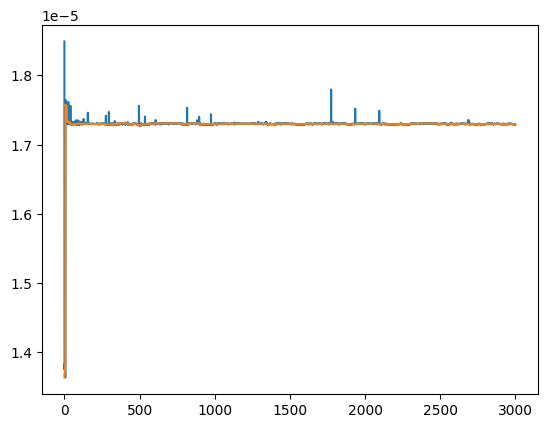

In [139]:
import scipy.signal as ssi
import matplotlib.pyplot as plt
plt.figure()
plt.plot(timeseries)
plt.plot(ssi.medfilt(timeseries,kernel_size=15))
plt.show()

In [140]:
P, warmup_end = ssd.detect_steady_state(timeseries, prob_win_size=100, t_crit=1.9, step_win_size=50, medfilt_kernel_size=15)
print(f'new warmup_end: {warmup_end}')
print(f'original classification of warmup: {classification}')
# print(timeseries[:20])

new warmup_end: 2998
original classification of warmup: 0


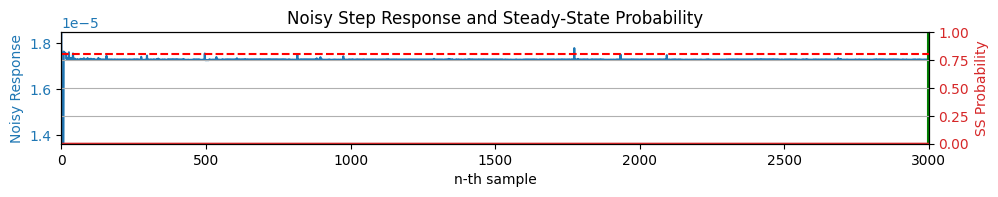

(0, 2999): 0.0


In [141]:
ssd.print_fork(timeseries, P, warmup_end, classification, min(timeseries), max(timeseries))

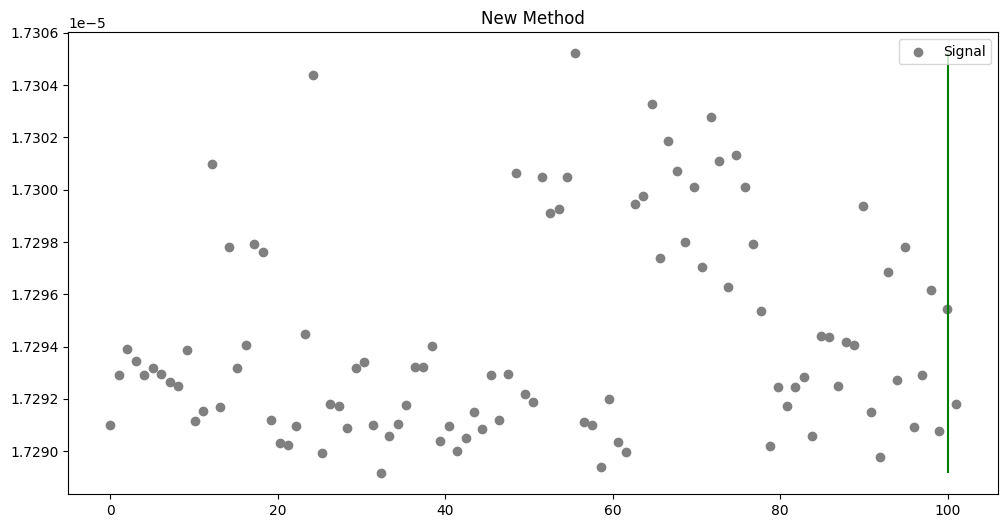

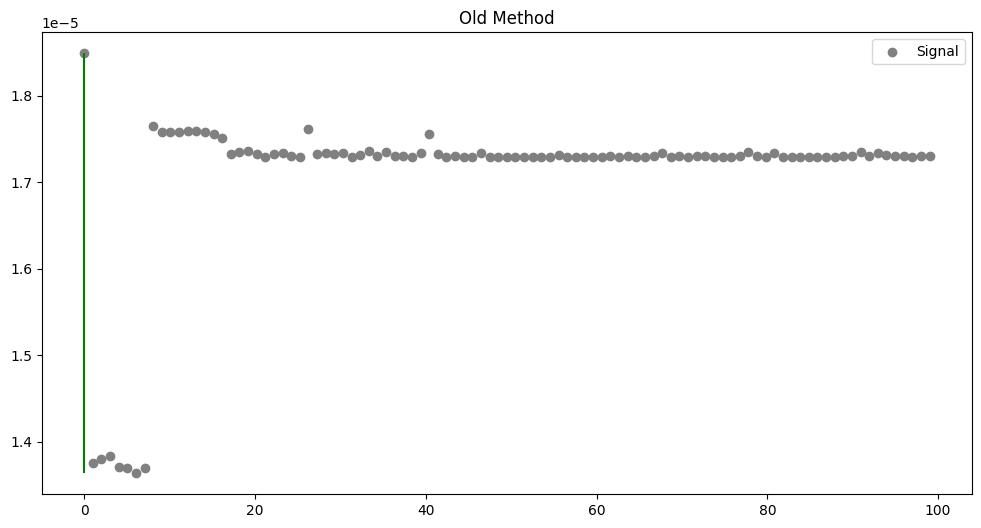

In [142]:
window = 100
ssd.plot_step(timeseries, warmup_end, window, 'New Method')
ssd.plot_step(timeseries, classification, window, 'Old Method')

Difference in medians: 9.171622493044779e-09
Median of all data: 1.7299571899981777e-05


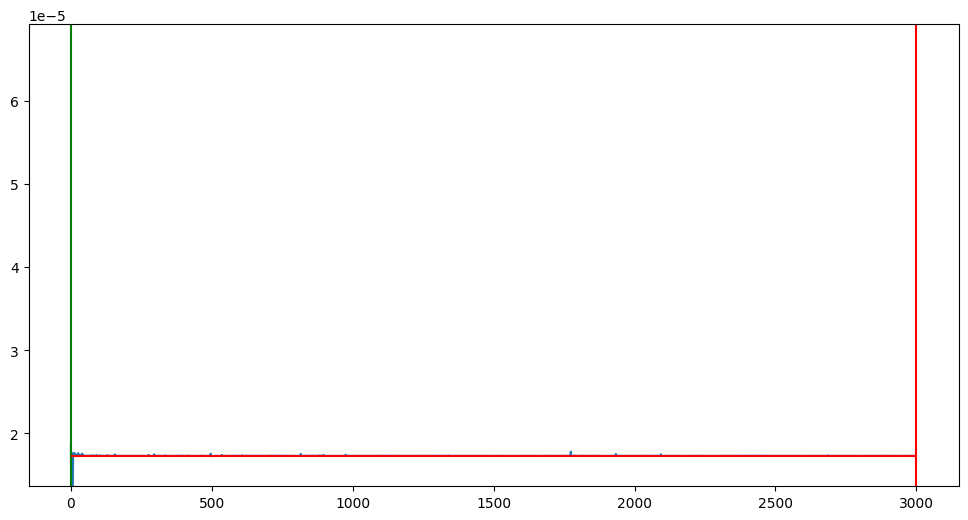

In [143]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(timeseries)
plt.ylim(min(timeseries), 4*np.median(timeseries))
plt.vlines(warmup_end, min(timeseries), 4*np.median(timeseries), colors='r')
plt.vlines(classification,min(timeseries), 4*np.median(timeseries), colors='g')
plt.hlines(np.median(timeseries[:warmup_end]),0, warmup_end, colors='r')
plt.hlines(np.median(timeseries[warmup_end:]),warmup_end, len(timeseries),colors='g')
print(f'Difference in medians: {np.median(timeseries[:warmup_end])-np.median(timeseries[warmup_end:])}')
print(f'Median of all data: {np.median(timeseries)}')

plt.show()

In [144]:
path = f'{data_dir}/timeseries/all'

import shutil
shutil.rmtree(f'{data_dir}/new_classification')
os.mkdir(f'{data_dir}/new_classification')

for filename in os.listdir(path):
    f = os.path.join(path, filename)

    if os.path.isfile(f):
        print(filename)
        # Read all the forks for the configuration
        forks = json.load(open(os.path.join(path, filename)))

        single_config_res = []

        # Iterate over forks
        for i, fork in enumerate(forks):
            print(f'Fork ID: {i}')
            # P, warmup_end = ssd.detect_steady_state(fork, prob_win_size=100, t_crit=1.9, step_win_size=50, medfilt_kernel_size=15)
            P, warmup_end = ssd.detect_steady_state(fork, prob_win_size=100, t_crit=1.9, step_win_size=50, medfilt_kernel_size=15)
            single_config_res.append(ssd.get_compact_result(P, warmup_end))

        json.dump(single_config_res, open(f'{data_dir}/new_classification/{filename}', 'w+'), indent=4)

imglib__imglib2#net.imglib2.loops.SyncedPositionablesBenchmark.benchmark2#.json
Fork ID: 0
Fork ID: 1
Fork ID: 2
Fork ID: 3
Fork ID: 4
Fork ID: 5
Fork ID: 6
Fork ID: 7
Fork ID: 8
Fork ID: 9
jdbi__jdbi#org.jdbi.v3.benchmark.QualifiersBenchmark.neq4To4#.json
Fork ID: 0
Fork ID: 1
Fork ID: 2
Fork ID: 3
Fork ID: 4
Fork ID: 5
Fork ID: 6
Fork ID: 7
Fork ID: 8
Fork ID: 9
eclipse__rdf4j#org.eclipse.rdf4j.benchmark.ReasoningBenchmark.noReasoningMultipleTransactions#param=simple::152.json
Fork ID: 0
Fork ID: 1
Fork ID: 2
Fork ID: 3
Fork ID: 4
Fork ID: 5
Fork ID: 6
Fork ID: 7
Fork ID: 8
Fork ID: 9
apache__tinkerpop#org.apache.tinkerpop.gremlin.driver.GraphBinaryReaderWriterBenchmark.readP1#.json
Fork ID: 0
Fork ID: 1
Fork ID: 2
Fork ID: 3
Fork ID: 4
Fork ID: 5
Fork ID: 6
Fork ID: 7
Fork ID: 8
Fork ID: 9
h2oai__h2o-3#water.util.IcedHashMapBench.writeMap#arrayType=PrimitiveArray&array_values_length=10000&keyType=String&n_entries=10&valueType=Boolean.json
Fork ID: 0
Fork ID: 1
Fork ID: 2
Fork ID: 3
